<div style="text-align: center;">

## A Tutorial on Score-Based Generative Model from Scratch with JaxAIStack 
### Hai Nguyen
### The University of Texas at Austin
### Aerospace Engineering and Engineering Mechanics
#### 2025 June 30

</div>


#### This notebook is a mixed version of theory and implementation of a score-based genrerative model. Materials for this notebook
- Tutorial notebook on Score-based model: [notebook1](https://colab.research.google.com/drive/1SeXMpILhkJPjXUaesvzEhc3Ke6Zl_zxJ?usp=sharing#scrollTo=LZC7wrOvxLdL), [notebook2](https://deeplearning.neuromatch.io/tutorials/W2D4_GenerativeModels/student/W2D4_Tutorial2.html)
- The blog post on Score-based model: [Yang Song's blog](https://yang-song.net/blog/2021/score/)
- papers:
  - [Pascal Vincent (2011), A connection between score matching and denoising autoencoders](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf)
  - [Calvin Luo (2022), Understanding Diffusion Models: A Unified Perspective](https://arxiv.org/abs/2208.11970)

## What is a generative model?

It is a model (function) that can generate samples similar to the data samples $x_1, x_2, \ldots, x_N \sim p(x)$ which it has been trained on. For example, a generative model trained on images of cats, $p_\text{cat}(x)$, can generate new images that look like cats. There are many types of neural network generative models (more available at this [online course](https://online.stanford.edu/courses/xcs236-deep-generative-models)), such as:
- Variational Autoencoders (VAEs)
- Generative Adversarial Networks (GANs)
- Diffusion models
- Score-based generative models
- Energy-based models
- Normalizing Flows

At very high level, the generative model $\mathcal{M}_{\theta}$ maps a `simple` distribution (e.g., Gaussian noise, $\mathcal{N}(0,I)$) to the data distribution. Here, `simple` means can be obtained by computer-generator. For example, we want to generate an image of $128\times 128$, we first draw a random noise `$r=np.random.randn(128, 128)` and then generate an artificial image $x_\text{generated}=\mathcal{M}_{\theta}(r)$.

In this tutorial, we will focus on **score-based generative models** which is the SOTA framework.




## What is data distribution $p(x)$?

We say "the generative model learns the data distribution $p(x)$", but what is $p(x)$? 

Theoretically, $p(x)$ is called the probability density function (pdf) of the data distribution, which is a function that describes the likelihood of each possible value of $x$. For example, if we have a dataset of images of cats, the pdf $p(x)$ describes the likelihood of each possible image of a cat. If we provide the image of dog or anything else, the pdf $p(x)$ will be very small (close to zero) because it is not a cat image. $p(cat)$ is large (depends on how popular of the type of cat in the cat image dataset), while $p(dog)\approx 0$ or $p(random)\approx 0$.

In reality, technically, we `never` know the analytical data distribution $p(x)$, we only have samples (data) from it, say $x_1, x_2, \ldots, x_N \sim p(x)$. For example, if we have a dataset of images of cats, we just assume/called that the images of cats are sampled from a distribution $p_\text{cat}(x)$, but there is no formula for $p_\text{cat}$.

There is no $p(x)$, then, how we go from **random** image to **cat** image, in other words, climbing from $p(random)\approx 0$ to a high $p(cat)$?


![Alt text](images/my_image.png)
<!-- ### A few intuitions from engineering perspective on the score-based generative model -->


## Score-Based Generative Model

The score-based generative model offers a rigorous framework to gradually transform 



<div align="center">
<img src="images/my_image.png" width="600">
</div>

## Notes: score-based model vs. diffusion model

In the field, [**score-based model**](https://yang-song.net/blog/2021/score/) and [**diffusion models**](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) are often used interchangeably. At first, they were developed semi-independently, so they have different formulations and notations. On the surface.

* Diffusion model uses a discrete Markov chain as a forward process. The objective is derived via the Evidence Lower Bound (ELBO) of the latent model.
* Score-based model usually uses continuous-time stochastic differential equation (SDE). The objective is derived via denoising score matching.

In the end, they were found to be equivalent, as one is roughly the discretization of the other. Here we focus on the **continuous time** framework.

In [48]:
from ipywidgets import widgets
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import seaborn as sns

# @title Plotting functions
import logging
import pandas as pd
import matplotlib.lines as mlines
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams['axes.unicode_minus'] = False
# You may have functions that plot results that aren't
# particularly interesting. You can add these here to hide them.

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps

   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )


def kdeplot(pnts, label="", ax=None, titlestr=None, handles=[], color="", **kwargs):
  if ax is None:
    ax = plt.gca()#figh, axs = plt.subplots(1,1,figsize=[6.5, 6])
  sns.kdeplot(x=pnts[:,0], y=pnts[:,1], ax=ax, label=label, color=color, **kwargs)
  handles.append(mlines.Line2D([], [], color=color, label=label))
  if titlestr is not None:
    ax.set_title(titlestr)


def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)


def gmm_pdf_contour_plot(gmm, xlim=None,ylim=None,ticks=100,logprob=False,label=None,**kwargs):
    if xlim is None:
        xlim = plt.xlim()
    if ylim is None:
        ylim = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, ticks), np.linspace(*ylim, ticks))
    pdf = gmm.pdf(np.dstack((xx,yy)))
    if logprob:
        pdf = np.log(pdf)
    plt.contour(xx, yy, pdf, **kwargs,)


def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

# Section 1: Understanding Score and Diffusion (analytically)

## Section 1.1:  Diffusion Process 
### forward process

In this section, we'd like to understand the forward diffusion process, and gain intuition about how diffusion turns data into "noise".

In this tutorial, we will use the process also known as Variance Exploding SDE (VPSDE) in diffusion literature.

\begin{equation}
d\mathbf x=g(t)d\mathbf w
\end{equation}

$d\mathbf w$ is the differential of the Wiener process, which is like the Gaussian random noise; $g(t)$ is the diffusion coefficient at time $t$. In our code, we can discretize it as:

\begin{equation}
\mathbf{x}_{t+\Delta t} = \mathbf{x}_{t}+g(t) \sqrt{\Delta t} z_t
\end{equation}

where $z_t\sim \mathcal{N} (0,I)$ are independent and identically distributed (i.i.d.) normal random variable.

Given an initial state $\mathbf{x}_0$ the conditional distribution of $\mathbf{x}_t$ is a Gaussian around $\mathbf x_0$:

\begin{equation}
p(\mathbf{x}_t\mid \mathbf{x}_0) = \mathcal N(\mathbf{x}_t;\mathbf{x}_0,\sigma_t^2 I)
\end{equation}

The key quantity to note is the $\sigma_t$ which is the integrated noise scale at time $t$. $I$ denotes the identity matrix.

\begin{equation}
\sigma_t^2=∫_0^t g^2(\tau)d\tau
\end{equation}

Marginalizing over all the initial states, the distribution of $\mathbf x_t$ is $p_t(x_t)$, i.e., convolving a Gaussian over the initial data distribution $p_0(\mathbf x_0)$ which blurs the data up.

\begin{equation}
p_t(\mathbf{x}_t) = \int_{\mathbf x_0} p_0(\mathbf x_0)\mathcal N(\mathbf{x}_t;\mathbf{x}_0,\sigma_t^2 I)
\end{equation}

### Interactive Demo 1.1: Visualizing diffusion

Here, we will examine the evolution of the density of a distribution $p_t(\mathbf{x})$ undergoing forward diffusion. In this case, we let $g(t)=\lambda^{t}$.

In [64]:
# @title 1D diffusion process
@widgets.interact
def diffusion_1d_forward(Lambda=(0, 50, 1), ):
    np.random.seed(0)
    timesteps = 100
    sampleN = 200
    t = np.linspace(0, 1, timesteps)
    # Generate random normal samples for the Wiener process
    dw = np.random.normal(0, np.sqrt(t[1] - t[0]), size=(len(t), sampleN))  # Three-dimensional array for multiple trajectories
    # Sample initial positions from a bimodal distribution
    x0 = np.concatenate((np.random.normal(-5, 1, size=(sampleN//2)),
                        np.random.normal(5, 1, size=(sampleN - sampleN//2))), axis=-1)
    # Compute the diffusion process for multiple trajectories
    x = np.cumsum((Lambda**t[:,None]) * dw, axis=0) + x0.reshape(1,sampleN)  # Broadcasting x0 to match the shape of dw
    # Plot the diffusion process
    plt.plot(t, x[:,:sampleN//2], alpha=0.1, color="r") # traj from first mode
    plt.plot(t, x[:,sampleN//2:], alpha=0.1, color="b") # traj from second mode
    plt.xlabel('Time')
    plt.ylabel('x')
    plt.title('Diffusion Process with $g(t)=\lambda^{t}$'+f' where $\lambda$={Lambda}')
    plt.grid(True)
    plt.show()

interactive(children=(IntSlider(value=25, description='Lambda', max=50), Output()), _dom_classes=('widget-inte…

In [62]:
# @title 2D diffusion process
# @markdown (the animation takes a while to render)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Lambda = 26  # @param {type:"slider", min:1, max:50, step:1}
timesteps = 50
sampleN = 200
t = np.linspace(0, 1, timesteps)
# Generate random normal samples for the Wiener process
dw = np.random.normal(0, np.sqrt(t[1] - t[0]), size=(len(t), 2, sampleN))  # Three-dimensional array for multiple trajectories
# Sample initial positions from a bimodal distribution
x0 = np.concatenate((np.random.normal(-2, .2, size=(2,sampleN//2)),
                     np.random.normal(2, .2, size=(2,sampleN - sampleN//2))),
                    axis=-1)
# Compute the diffusion process for multiple trajectories
x = np.cumsum((Lambda**t)[:, None, None] * dw, axis=0) + x0[None, :, :]  # Broadcasting x0 to match the shape of dw

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.axis("equal")
# Create an empty scatter plot
scatter1 = ax.scatter([], [], color="r", alpha=0.5)
scatter2 = ax.scatter([], [], color="b", alpha=0.5)
# Update function for the animation
def update(frame):
  ax.set_title(f'Time Step: {frame}')
  scatter1.set_offsets(x[frame, :, :sampleN//2].T)
  scatter2.set_offsets(x[frame, :, sampleN//2:].T)
  return scatter1, scatter2

# Create the animation
animation = FuncAnimation(fig, update, frames=range(timesteps), interval=100, blit=True)
# Display the animation
plt.close()  # Prevents displaying the initial static plot
HTML(animation.to_jshtml())  # Fixed: Use to_jshtml() instead of to_html5_video()

## Section 1.2:  What is Score

The big idea of diffusion model is to use the **"score" function** to reverse the diffusion process. So what is score, what's the intuition to it? 


The **Score** is the gradient of the log data distribution, so it tells us which direction to go to increase the probability of data.

\begin{equation}
\mathbf{s}(\mathbf{x})=\nabla \log p(\mathbf{x})
\end{equation}

### Coding Exercise 1.2: Score for Gaussian Mixtures

In this exercise, you will explore the score function of a Gaussian mixture to gain more intuition about its geometry.

In [21]:
# @title  Custom Gaussian Mixture class
# @markdown *Execute this cell to define the class Gaussian Mixture Model for our exercise*

from scipy.stats import multivariate_normal

class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs
    self.precs = [np.linalg.inv(cov) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])

  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov))
    self.RVs.append(multivariate_normal(mu, cov))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1

  def pdf_decompose(self, x):
    """
      probability density (PDF) at $x$.
    """
    component_pdf = []
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
        component_pdf.append(pdf)
    component_pdf = np.array(component_pdf)
    return prob, component_pdf

  def pdf(self, x):
    """
      probability density (PDF) at $x$.
    """
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
    # component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    # prob = np.dot(component_pdf, self.norm_weights)
    return prob

  def score(self, x):
    """
    Compute the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    scores = np.zeros_like(x)
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      scores += participance[:, i:i+1] * gradvec

    return scores

  def score_decompose(self, x):
    """
    Compute the grad to each branch for the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    gradvec_list = []
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      gradvec_list.append(gradvec)
      # scores += participance[:, i:i+1] * gradvec

    return gradvec_list, participance

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

### Example: Gaussian mixture model

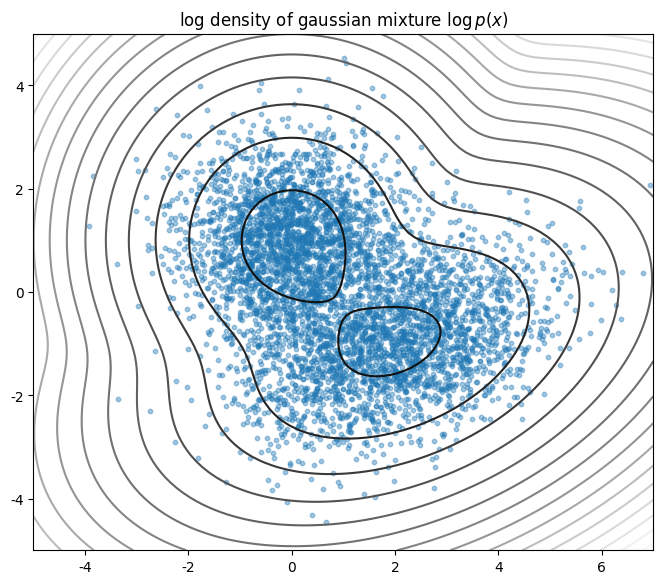

In [30]:
# Gaussian mixture
mu1 = np.array([0, 1.0])
Cov1 = np.array([[1.0, 0.0], [0.0, 1.0]])

mu2 = np.array([2.0, -1.0])
Cov2 = np.array([[2.0, 0.5], [0.5, 1.0]])

gmm = GaussianMixture([mu1, mu2],[Cov1, Cov2], [1.0, 1.0])

# @title Visualize log density
show_samples = True  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples, _, _ = gmm.sample(5000)
plt.figure(figsize=[8, 8])
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
gmm_pdf_contour_plot(gmm, cmap="Greys", levels=20, logprob=True,
                     xlim=(-5, 7), ylim=(-5, 5))
plt.title("log density of gaussian mixture $\log p(x)$")
plt.axis("image")
plt.show()

#### Visualize Score

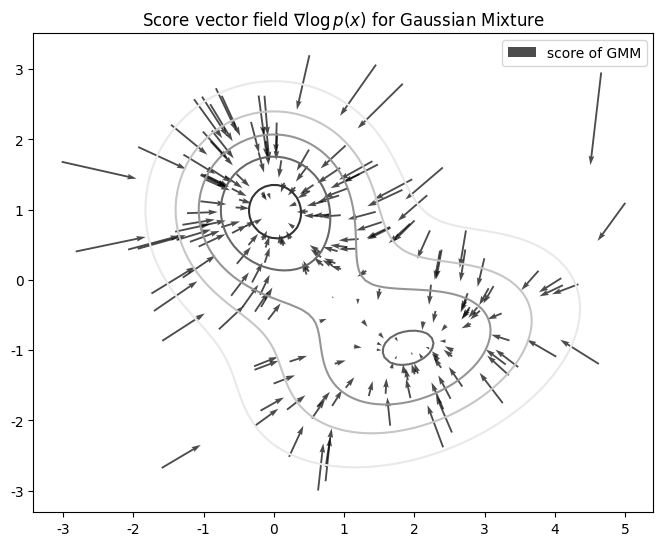

In [33]:
# @title Visualize Score
# set_seed(2023)
gmm_samps_few, _, _ = gmm.sample(200)
scorevecs_few = gmm.score(gmm_samps_few)
gradvec_list, participance = gmm.score_decompose(gmm_samps_few)

# @title Score for Gaussian mixture
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, scorevecs_few,
            color="black", scale=25, alpha=0.7, width=0.003,
            label="score of GMM")
gmm_pdf_contour_plot(gmm, cmap="Greys")
plt.title("Score vector field $\\nabla\log p(x)$ for Gaussian Mixture")
plt.axis("image")
plt.legend()
plt.show()

#### Score for each Gaussian mode

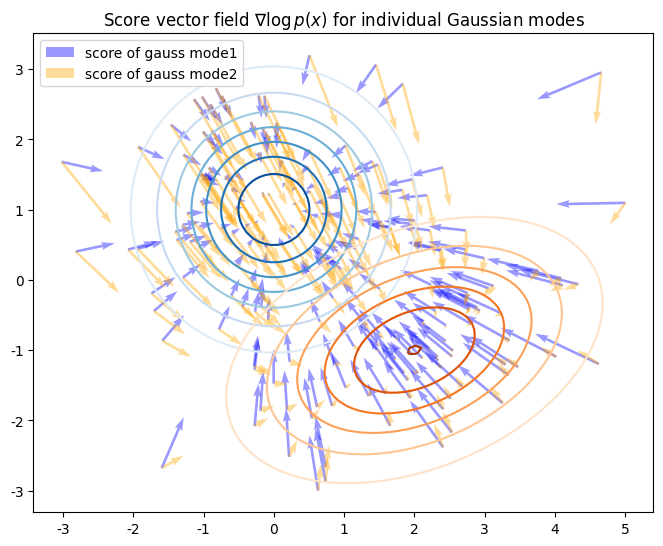

In [34]:
# @title Score for each Gaussian mode
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, gradvec_list[0],
            color="blue", alpha=0.4, scale=45,
            label="score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1],
            color="orange", alpha=0.4, scale=45,
            label="score of gauss mode2")
gmm_pdf_contour_plot(gmm.RVs[0], cmap="Blues")
gmm_pdf_contour_plot(gmm.RVs[1], cmap="Oranges")
plt.title("Score vector field $\\nabla\log p(x)$ for individual Gaussian modes")
plt.axis("image")
plt.legend()
plt.show()

#### Compare Score of individual mode with that of the mixture.

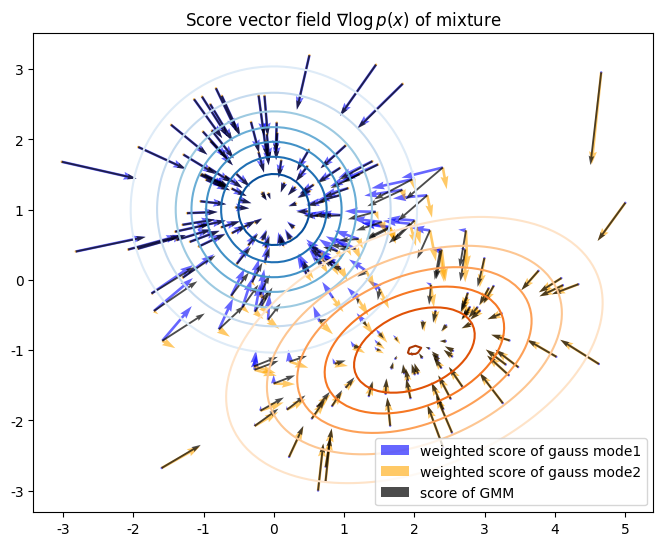

In [35]:
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, gradvec_list[0]*participance[:, 0:1],
            color="blue", alpha=0.6, scale=25,
            label="weighted score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1]*participance[:, 1:2],
            color="orange", alpha=0.6, scale=25,
            label="weighted score of gauss mode2")
quiver_plot(gmm_samps_few, scorevecs_few, color="black", scale=25, alpha=0.7,
            width=0.003, label="score of GMM")
gmm_pdf_contour_plot(gmm.RVs[0], cmap="Blues")
gmm_pdf_contour_plot(gmm.RVs[1], cmap="Oranges")
plt.title("Score vector field $\\nabla\log p(x)$ of mixture")
plt.axis("image")
plt.legend()
plt.show()

### Think! 1.2: What does score tell us?

What does the score's **magnitude and direction** tell us in general?

For a **multi-modal distribution**, how does the score of the individual mode relate to the overall score?


## Section 1.3:  Reverse Diffusion

After getting some intuition about the score function, we are now well-equipped to reverse the diffusion process!

There is [a result in stochastic process literature](https://www.sciencedirect.com/science/article/pii/0304414982900515) that if we have the forward process

\begin{equation}
d\mathbf{x} = g(t)d \mathbf{w}
\end{equation}

Then the following process (reverse SDE) will be its time reversal:

\begin{equation}
d\mathbf{x} = -g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + g(t) d \mathbf{w}.
\end{equation}

where time $t$ runs backward.

<br>

**Time Reversal**: The solution of forward SDE is a sequence of distribution $p_t(\mathbf{x})$ from $t=0\to T$. If we start the reverse SDE with the initial distribution $p_T(\mathbf{x})$, then its solution will be the same sequence of distribution $p_t(\mathbf{x})$, but only that $t=T\to 0$.

**Note:** For the general form of this result, see the Bonus section at the end of this tutorial.

**Implication**  This time reversal is the foundation of the Diffusion model. We can use an interesting distribution as $p_0(\mathbf x)$ connects it with noise via forward diffusion.

Then we can sample the noise and convert it back to data via the reverse diffusion process.

<br>

<p align='center'><img src='https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/static/noising_process.png?raw=True'/></p>

In [36]:
# @markdown Helper functions: `sigma_t_square` and `diffuse_gmm`
def sigma_t_square(t, Lambda):
    """Compute the noise variance \sigma_t^2 of the conditional distribution
    for forward process with g(t)=\lambda^t

    Formula
      \sigma_t^2 = \frac{\sigma^{2\lambda} - 1}{2 \ln(\lambda)}

    Args:
      t (scalar or ndarray): time
      Lambda (scalar): Lambda

    Returns:
      sigma_t^2
    """
    return (Lambda**(2 * t) - 1) / (2 * np.log(Lambda))


def sigma_t(t, Lambda):
    """Compute the noise std \sigma_t of the conditional distribution
    for forward process with g(t)=\lambda^t

    Formula
      \sigma_t =\sqrt{ \frac{\sigma^{2\lambda} - 1}{2 \ln(\lambda)}}

    Args:
      t (scalar or ndarray): time
      Lambda (scalar): Lambda

    Returns:
      sigma_t
    """
    return np.sqrt((Lambda**(2 * t) - 1) / (2 * np.log(Lambda)))


def diffuse_gmm(gmm, t, Lambda):
  """ Teleport a Gaussian Mixture distribution to $t$ by diffusion forward process

  The distribution p_t(x) (still a Gaussian mixture)
    following the forward diffusion SDE
  """
  sigma_t_2 = sigma_t_square(t, Lambda)  # variance
  noise_cov = np.eye(gmm.dim) * sigma_t_2
  covs_dif = [cov + noise_cov for cov in gmm.covs]
  return GaussianMixture(gmm.mus, covs_dif, gmm.weights)

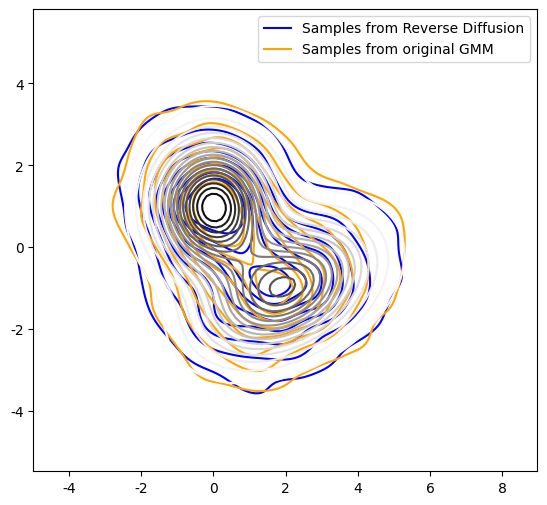

In [ ]:
# to_remove solution
def reverse_diffusion_SDE_sampling_gmm(gmm, sampN=500, Lambda=5, nsteps=500):
  """ Using exact score function to simulate the reverse SDE to sample from distribution.

  gmm: Gausian Mixture model class defined above
  sampN: Number of samples to generate
  Lambda: the $\lambda$ used in the diffusion coefficient $g(t)=\lambda^t$
  nsteps: how many discrete steps do we use to
  """
  # initial distribution $N(0,sigma_T^2 I)$
  sigmaT2 = sigma_t_square(1, Lambda)
  xT = np.sqrt(sigmaT2) * np.random.randn(sampN, 2)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    # note the time fly back $t$
    t = 1 - i * dt

    # Sample the Gaussian noise $z ~ N(0, I)$
    eps_z = np.random.randn(*xT.shape)

    # Transport the gmm to that at time $t$ and
    gmm_t = diffuse_gmm(gmm, t, Lambda)

    # Compute the score at state $x_t$ and time $t$, $\nabla \log p_t(x_t)$
    score_xt = gmm_t.score(x_traj_rev[:, :, i-1])

    # Implement the one time step update equation
    x_traj_rev[:, :, i] = x_traj_rev[:, :, i-1] + eps_z * (Lambda ** t) * np.sqrt(dt) + score_xt * dt * Lambda**(2*t)
  return x_traj_rev


## Uncomment the code below to test your function
# set_seed(42)
x_traj_rev = reverse_diffusion_SDE_sampling_gmm(gmm, sampN=2500, Lambda=10, nsteps=200)
x0_rev = x_traj_rev[:, :, -1]
gmm_samples, _, _ = gmm.sample(2500)

figh, axs = plt.subplots(1, 1, figsize=[6.5, 6])
handles = []
kdeplot(x0_rev, "Samples from Reverse Diffusion", ax=axs, handles=handles, color="blue")
kdeplot(gmm_samples, "Samples from original GMM", ax=axs, handles=handles, color="orange")
gmm_pdf_contour_plot(gmm, cmap="Greys", levels=20)  # the exact pdf contour of gmm
plt.legend(handles=handles)
figh.show()

# Neural network score-based model

Training JAX model...
Sampling 10000 (X, t, score) for training
Sampling 2000 (X, t, score) for testing
Define neural network score approximator
Minimizing the denoising score matching objective


  0%|          | 0/500 [00:00<?, ?it/s]

step 0 DSM loss 2.884 train score MSE 1.594 test score MSE 1.596
step 25 DSM loss 0.963 train score MSE 0.983 test score MSE 1.007
step 50 DSM loss 0.901 train score MSE 0.829 test score MSE 0.852
step 75 DSM loss 0.868 train score MSE 0.801 test score MSE 0.827
step 100 DSM loss 0.874 train score MSE 0.785 test score MSE 0.806
step 125 DSM loss 0.865 train score MSE 0.775 test score MSE 0.800
step 150 DSM loss 0.848 train score MSE 0.769 test score MSE 0.795
step 175 DSM loss 0.874 train score MSE 0.763 test score MSE 0.786
step 200 DSM loss 0.851 train score MSE 0.751 test score MSE 0.774
step 225 DSM loss 0.878 train score MSE 0.748 test score MSE 0.771
step 250 DSM loss 0.851 train score MSE 0.742 test score MSE 0.765
step 275 DSM loss 0.847 train score MSE 0.743 test score MSE 0.769
step 300 DSM loss 0.856 train score MSE 0.745 test score MSE 0.767
step 325 DSM loss 0.842 train score MSE 0.740 test score MSE 0.764
step 350 DSM loss 0.834 train score MSE 0.739 test score MSE 0.760


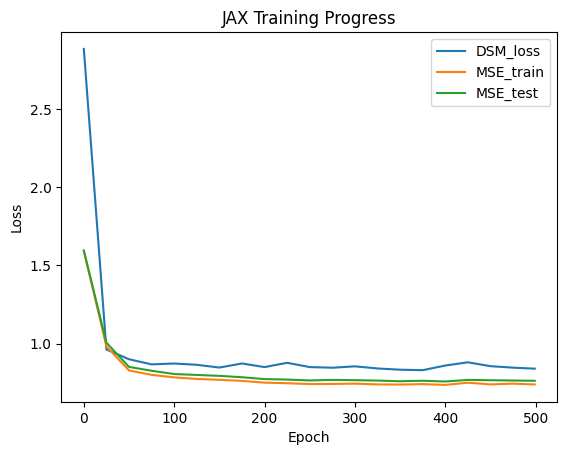

Sampling with reverse SDE using the trained JAX score model
Sampling with reverse SDE using the exact score of Gaussian mixture
Sampling from original Gaussian mixture
Comparing the distributions


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


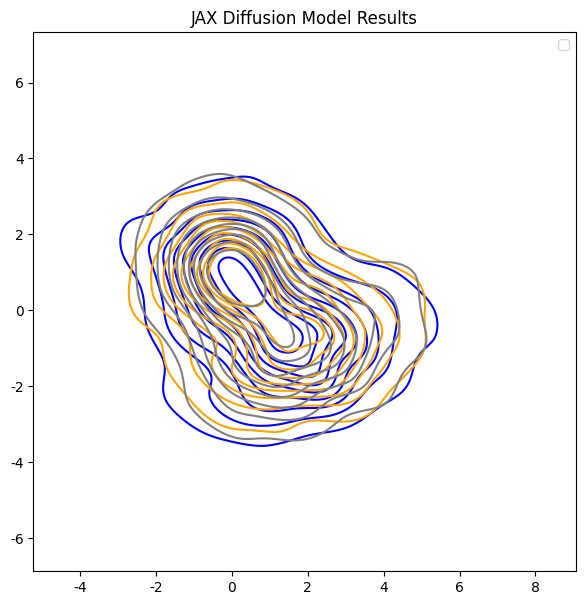

In [45]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import flax.linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange
from functools import partial

# Set JAX to use float32 for better performance
jax.config.update("jax_enable_x64", False)

# %%
def loss_fn_jax(params, model_apply, x, sigma_t_fun, key, eps=1e-5):
    """JAX version of the loss function for training score-based generative models.

    Args:
        params: Model parameters
        model_apply: Model apply function
        x: A mini-batch of training data
        sigma_t_fun: A function that gives the standard deviation
        key: JAX random key
        eps: A tolerance value for numerical stability
    """
    batch_size = x.shape[0]
    
    # Sample random time steps
    key, subkey = random.split(key)
    random_t = random.uniform(subkey, (batch_size,), minval=eps, maxval=1.0)
    
    # Sample noise
    key, subkey = random.split(key)
    z = random.normal(subkey, x.shape)
    
    # Get standard deviation
    std = sigma_t_fun(random_t)
    
    # Create perturbed data
    perturbed_x = x + z * std[:, None]
    
    # Predict score using the model
    score = model_apply(params, perturbed_x, random_t)
    
    # Compute loss: ||σ_t * s_θ(x + σ_t * z, t) + z||^2
    loss_per_sample = jnp.sum((score * std[:, None] + z)**2, axis=1)
    loss = jnp.mean(loss_per_sample)
    
    return loss

# %%
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps in JAX/Flax."""
    embed_dim: int
    scale: float = 30.0
    
    def setup(self):
        # Create fixed random weights (not trainable)
        self.W = self.param('W', 
                           lambda key: random.normal(key, (self.embed_dim // 2,)) * self.scale)
    
    def __call__(self, t):
        t_proj = t[:, None] * self.W[None, :] * 2 * jnp.pi
        return jnp.concatenate([jnp.sin(t_proj), jnp.cos(t_proj)], axis=-1)

class ScoreModel_Time_JAX(nn.Module):
    """A time-dependent score-based model in JAX/Flax."""
    sigma: float
    
    def setup(self):
        self.embed = GaussianFourierProjection(embed_dim=10, scale=1.0)
        self.net = nn.Sequential([
            nn.Dense(50),
            nn.tanh,
            nn.Dense(50), 
            nn.tanh,
            nn.Dense(2)
        ])
    
    def sigma_t_fun(self, t):
        return jnp.sqrt(sigma_t_square_jax(t, self.sigma))
    
    def __call__(self, x, t):
        t_embed = self.embed(t)
        input_features = jnp.concatenate([x, t_embed], axis=1)
        pred = self.net(input_features)
        
        # Apply inductive bias: normalize by sigma_t
        pred = pred / self.sigma_t_fun(t)[:, None]
        return pred

# %%
def sigma_t_square_jax(t, Lambda):
    """JAX version of sigma_t_square function"""
    return (Lambda**(2 * t) - 1) / (2 * jnp.log(Lambda))

def sigma_t_jax(t, Lambda):
    """JAX version of sigma_t function"""
    return jnp.sqrt(sigma_t_square_jax(t, Lambda))

# %%
def sample_X_and_score_t_depend_jax(gmm, trainN=10000, sigma=5, partition=20, EPS=0.02):
    """JAX version of sampling function"""
    trainN_part = trainN // partition
    X_train_col, y_train_col, T_train_col = [], [], []
    
    for t in np.linspace(EPS, 1.0, partition):
        gmm_dif = diffuse_gmm(gmm, t, sigma)
        X_train, _, _ = gmm.sample(trainN_part)
        y_train = gmm.score(X_train)
        
        X_train_jax = jnp.array(X_train, dtype=jnp.float32)
        y_train_jax = jnp.array(y_train, dtype=jnp.float32)
        T_train_jax = jnp.full((trainN_part,), t, dtype=jnp.float32)
        
        X_train_col.append(X_train_jax)
        y_train_col.append(y_train_jax)
        T_train_col.append(T_train_jax)
    
    X_train_jax = jnp.concatenate(X_train_col, axis=0)
    y_train_jax = jnp.concatenate(y_train_col, axis=0)
    T_train_jax = jnp.concatenate(T_train_col, axis=0)
    
    return X_train_jax, y_train_jax, T_train_jax

# %%
def test_DSM_objective_jax(gmm, epochs=500, seed=0):
    """JAX version of the DSM objective test"""
    key = random.PRNGKey(seed)
    sigma = 25.0
    
    print("Sampling 10000 (X, t, score) for training")
    X_train_samp, y_train_samp, T_train_samp = \
        sample_X_and_score_t_depend_jax(gmm, sigma=sigma, trainN=10000,
                                        partition=500, EPS=0.01)
    
    print("Sampling 2000 (X, t, score) for testing")
    X_test_samp, y_test_samp, T_test_samp = \
        sample_X_and_score_t_depend_jax(gmm, sigma=sigma, trainN=2000,
                                        partition=500, EPS=0.01)
    
    print("Define neural network score approximator")
    model = ScoreModel_Time_JAX(sigma=sigma)
    
    # Initialize model parameters
    key, init_key = random.split(key)
    dummy_x = jnp.ones((1, 2))
    dummy_t = jnp.ones((1,))
    params = model.init(init_key, dummy_x, dummy_t)
    
    # Define sigma_t function
    sigma_t_f = lambda t: jnp.sqrt(sigma_t_square_jax(t, sigma))
    
    # Setup optimizer
    optimizer = optax.adam(learning_rate=0.005)
    opt_state = optimizer.init(params)
    
    # JIT compile the loss function and update step
    @jit
    def loss_fn_compiled(params, x, key):
        return loss_fn_jax(params, model.apply, x, sigma_t_f, key, eps=0.01)
    
    @jit
    def update_step(params, opt_state, x, key):
        loss, grads = jax.value_and_grad(loss_fn_compiled)(params, x, key)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    
    @jit
    def compute_mse(params, x_data, t_data, y_true):
        y_pred = model.apply(params, x_data, t_data)
        return jnp.mean(jnp.sum((y_true - y_pred)**2, axis=1))
    
    print("Minimizing the denoising score matching objective")
    stats = []
    pbar = trange(epochs)
    
    for ep in pbar:
        key, subkey = random.split(key)
        params, opt_state, loss = update_step(params, opt_state, X_train_samp, subkey)
        
        pbar.set_description(f"step {ep} DSM objective loss {loss:.3f}")
        
        if ep % 25 == 0 or ep == epochs - 1:
            # Compute MSE for train and test
            MSE_train = compute_mse(params, X_train_samp, T_train_samp, y_train_samp)
            MSE_test = compute_mse(params, X_test_samp, T_test_samp, y_test_samp)
            
            print(f"step {ep} DSM loss {loss:.3f} train score MSE {MSE_train:.3f} " +
                  f"test score MSE {MSE_test:.3f}")
            stats.append((ep, float(loss), float(MSE_train), float(MSE_test)))
    
    stats_df = pd.DataFrame(stats, columns=['ep', 'DSM_loss', 'MSE_train', 'MSE_test'])
    return model, params, stats_df

# %%
def reverse_diffusion_SDE_sampling_jax(model_or_gmm, params=None, sampN=500, Lambda=5,
                                      nsteps=200, ndim=2, exact=False, key=None):
    """JAX version of reverse diffusion sampling"""
    if key is None:
        key = random.PRNGKey(0)
    
    sigmaT2 = sigma_t_square_jax(1.0, Lambda)
    
    # Sample initial noise
    key, subkey = random.split(key)
    xT = jnp.sqrt(sigmaT2) * random.normal(subkey, (sampN, ndim))
    
    # Initialize trajectory array
    x_traj_rev = jnp.zeros((sampN, ndim, nsteps))
    x_traj_rev = x_traj_rev.at[:, :, 0].set(xT)
    
    dt = 1.0 / nsteps
    
    for i in range(1, nsteps):
        t = 1.0 - i * dt
        
        # Sample noise
        key, subkey = random.split(key)
        eps_z = random.normal(subkey, (sampN, ndim))
        
        current_x = x_traj_rev[:, :, i-1]
        
        if exact:
            # Use exact GMM score (convert to numpy for GMM operations)
            gmm_t = diffuse_gmm(model_or_gmm, t, Lambda)
            score_xt = gmm_t.score(np.array(current_x))
            score_xt = jnp.array(score_xt)
        else:
            # Use neural network
            tvec = jnp.full((sampN,), t)
            score_xt = model_or_gmm.apply(params, current_x, tvec)
        
        # Update step
        next_x = (current_x + 
                 eps_z * (Lambda ** t) * jnp.sqrt(dt) + 
                 score_xt * dt * Lambda**(2*t))
        
        x_traj_rev = x_traj_rev.at[:, :, i].set(next_x)
    
    return np.array(x_traj_rev)

# %%
# Usage example (assuming gmm and other dependencies are available):
def run_jax_example(gmm, SEED=2021):
    """Run the complete JAX example"""
    print("Training JAX model...")
    model, params, stats_df = test_DSM_objective_jax(gmm, epochs=500, seed=SEED)
    
    # Plot the losses
    print("Plotting losses...")
    stats_df.plot(x="ep", y=['DSM_loss', 'MSE_train', 'MSE_test'])
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("JAX Training Progress")
    plt.show()
    
    print("Sampling with reverse SDE using the trained JAX score model")
    key = random.PRNGKey(SEED)
    x_traj_rev_appr_denois = reverse_diffusion_SDE_sampling_jax(
        model, params, sampN=1000, Lambda=25, nsteps=200, ndim=2, key=key)
    
    print("Sampling with reverse SDE using the exact score of Gaussian mixture")
    key = random.PRNGKey(SEED + 1)
    x_traj_rev_exact = reverse_diffusion_SDE_sampling_jax(
        gmm, sampN=1000, Lambda=25, nsteps=200, ndim=2, exact=True, key=key)
    
    print("Sampling from original Gaussian mixture")
    X_samp, _, _ = gmm.sample(1000)
    
    print("Comparing the distributions")
    fig, ax = plt.subplots(figsize=[7, 7])
    handles = []
    
    # Note: You'll need to implement kdeplot or use seaborn
    # This is a placeholder for the plotting
    from sklearn.neighbors import KernelDensity
    import seaborn as sns
    
    # Plot using seaborn (assuming kdeplot is available)
    try:
        kdeplot(x_traj_rev_appr_denois[:, :, -1],
                label="Reverse diffusion (JAX NN score learned DSM)", 
                handles=handles, color="blue")
        kdeplot(x_traj_rev_exact[:, :, -1],
                label="Reverse diffusion (Exact score)", 
                handles=handles, color="orange")
        kdeplot(X_samp, label="Samples from original GMM", 
                handles=handles, color="gray")
    except:
        # Fallback to scatter plot
        plt.scatter(x_traj_rev_appr_denois[:, 0, -1], x_traj_rev_appr_denois[:, 1, -1],
                   alpha=0.5, color="blue", label="JAX NN Reverse Diffusion", s=10)
        plt.scatter(x_traj_rev_exact[:, 0, -1], x_traj_rev_exact[:, 1, -1],
                   alpha=0.5, color="orange", label="Exact Reverse Diffusion", s=10)
        plt.scatter(X_samp[:, 0], X_samp[:, 1],
                   alpha=0.5, color="gray", label="Original GMM", s=10)
    
    plt.axis("equal")
    plt.legend()
    plt.title("JAX Diffusion Model Results")
    plt.show()
    
    return model, params, stats_df

# Example usage:
model, params, stats_df = run_jax_example(gmm, SEED=2021)

---
# Summary

Bravo, we have come a long way today! We learned about:

* The forward and reverse diffusion processes connect the data and noise distributions.
* Sampling involves transforming noise into data through the reverse diffusion process.
* Score function is the gradient to the data distribution, enabling the diffusion process's time reversal.
* By learning to denoise, we can learn the score function of data by a function approximator, e.g., neural network.

The math that empowers the diffusion models is the reversibility of this stochastic process. Here is the general result that, given a forward diffusion process,

\begin{equation}
d\mathbf{x} = \mathbf{f}(\mathbf{x}, t)dt + g(t)d \mathbf{w}
\end{equation}

There exists a reverse time stochastic process (reverse SDE)

\begin{equation}
d\mathbf{x} =  \bigg[\mathbf{f}(\mathbf{x}, t) - g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x}) \bigg]dt + g(t) d \mathbf{w}.
\end{equation}

and a probability flow Ordinary Differential Equation (ODE)

\begin{equation}
d\mathbf{x} = \bigg[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2}g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x})\bigg] dt.
\end{equation}

such that solving the reverse SDE or the probability flow ODE amounts to the time reversal of the solution to the forward SDE.

By this math, simulating both the ODE and the SDE can sample from diffusion models.

# Bonus: The Math behind Score Matching Objective

How to fit the score based on the samples, when we have no access to the exact scores?

This objective is called denoising score matching. Mathematically, it utilized this [equivalence relationship](https://animadversio.github.io/academic_notes/note-on-equiv-score-matching-objective) of the following objectives.

$$\begin{align}
J_{DSM}(\theta) &=\mathbb{E}_{\tilde{x},x\sim p_t(\tilde{x},x)} \|s_\theta(\tilde{x})-\nabla_{\tilde{x}}\log p_t(\tilde{x}\mid x)\|^2\\
J_{ESM}(\theta) &=\mathbb{E}_{\tilde{x}\sim p_t(\tilde{x})} \|s_\theta(\tilde{x})-\nabla_{\tilde{x}}\log p_t(\tilde{x})\|^2
\end{align}$$

In practice, it's to sample $x$ from data distribution, add noise with $\sigma$ and denoise it. Since we have at time $t$, $p_t(\tilde{x}\mid x)= \mathcal{N}(\tilde{x};x,\sigma^2_t I)$, then $\tilde{x}=x+\sigma_t z,z\sim \mathcal{N}(0,I)$. Then

$$\nabla_{\tilde{x}}\log p_t(\tilde{x}|x)=-\frac{1}{\sigma_t^2}(x+\sigma_t z -x)=-\frac{1}{\sigma_t}z$$

The objective simplifies into

$$\mathbb{E}_{x\sim p_0(x)}\mathbb{E}_{z\sim \mathcal{N}(0,I)} \|s_\theta(x+\sigma_t z)+\frac{1}{\sigma_t}z\|^2$$

Finally, in the time dependent score model $s(x,t)$, to learn this for any time $t\in [\epsilon,1]$, we integrate over all $t$ with a certain weighting function $\gamma_t$ to emphasize certain part.

$$\int_\epsilon^1dt \gamma_t\mathbb{E}_{x\sim p_0(x)}\mathbb{E}_{z\sim \mathcal{N}(0,I)} \|s_\theta(x+\sigma_t z, t)+\frac{1}{\sigma_t}z\|^2$$

(the $\epsilon$ is set to ensure numerical stability, as $t\to 0,\sigma_t\to 0$)

Now all the expectations could be easily evaluated by sampling.

A commonly used weighting is the following:

$$\int_\epsilon^1dt \mathbb{E}_{x\sim p_0(x)}\mathbb{E}_{z\sim \mathcal{N}(0,I)} \|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2$$

---

**Reference**

* [Pascal Vincent (2011), A connection between score matching and denoising autoencoders](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf)